# MNIST With SET
This is an example of training an SET network on the MNIST dataset using synapses, pytorch, and torchvision.

In [1]:
#Import torch libraries and get SETLayer from synapses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from synapses import SETLayer

#Some extras for visualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
print("done")

done


## SET Layer
The SET layer is a pytorch module that works with a similar API to a standard fully connected layer; to initialize, specify input and output dimensions.<br><br>
NOTE: one condition mentioned in the paper is that epsilon (a hyperparameter controlling layer sparsity) be much less than the input dimension and much less than the output dimension. The default value of epsilon is 11. Keep dimensions much bigger than epsilon! (epsilon can be passed in as an init argument to the layer).

In [2]:
#initialize the layer
sprs = SETLayer(128, 256)

#We can see the layer transforms inputs as we expect
inp = torch.randn((2, 128))
print('Input batch shape: ', tuple(inp.shape))
out = sprs(inp)
print('Output batch shape: ', tuple(out.shape))

Input batch shape:  (2, 128)
Output batch shape:  (2, 256)


In terms of behavior, the SETLayer transforms an input vector into the output space as would a fcl.
## Initial Connection Distribution
The intialized layer has randomly assigned connections between input nodes and output nodes; each connection is associated with a weight, drawn from a normal distribution.

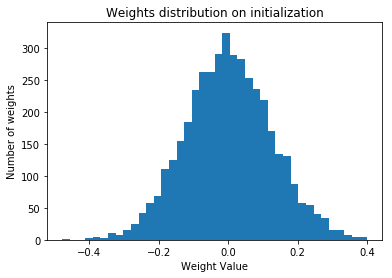

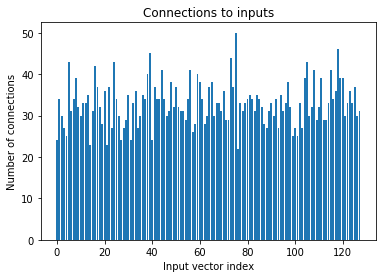

done


In [3]:
#Inspect init weight distribution
plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution on initialization')
plt.xlabel('Weight Value')
plt.ylabel('Number of weights')
plt.show()

vec = sprs.connections[:, 0]
vec = np.array(vec)
values, counts = np.unique(vec, return_counts=True)
plt.title('Connections to inputs')
plt.bar(values, counts)
plt.xlabel('Input vector index')
plt.ylabel('Number of connections')
plt.show()
print("done")

The weights are sampled from a normal distribution, as is done with a standard fcl. The connections to the inputs are uniformly distributed.<br><br>

## Killing Connections
When connections are reassigned in SET, some proportion (defined by hyperparameter zeta) of the weights closest to zero are removed. We can set these to zero using the zero_connections method on the layer. (This method leaves the connections unchanged.)

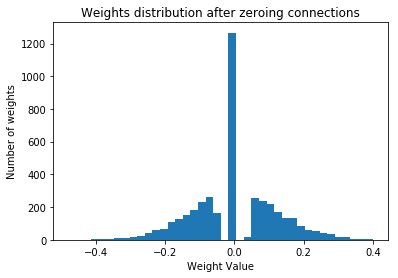

done


In [4]:
sprs.zero_connections()

#Inspect init weight distribution
plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution after zeroing connections')
plt.xlabel('Weight Value')
plt.ylabel('Number of weights')
plt.show()
print("done")

## Evolving Connections

The evolve_connections() method will reassign these weights to new connections between input and output nodes. By default, these weights are initialized by sampling from the same distribution as the init function. Optionally, these weights can be set at zero (with init=False argument).

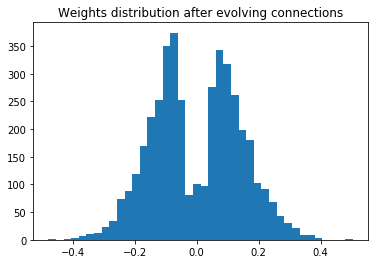

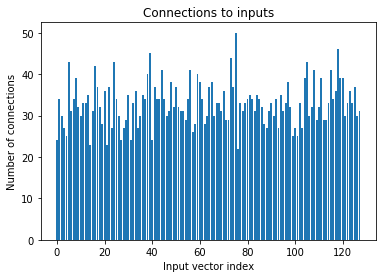

done


In [5]:
sprs.evolve_connections()

plt.hist(np.array(sprs.weight.data), bins=40)
plt.title('Weights distribution after evolving connections')
plt.show()

plt.title('Connections to inputs')
plt.bar(values, counts)
plt.xlabel('Input vector index')
plt.ylabel('Number of connections')
plt.show()
print("done")

We can see these weight values have been re-distributed; the new connections conform to the same uniform distribution as before. (We see in the SET paper, and here later on, that the adaptive algorithm learns to allocate these connections to more important input values.)

## A Simple SET Model

The following is a simple sparsely-connected model using SETLayers with default hyperparameters.

In [6]:
class SparseNet(nn.Module):
    def __init__(self):
        super(SparseNet, self).__init__()
        self.set_layers = []
        self.set1 = SETLayer(784, 512)
        self.set_layers.append(self.set1)
        #self.set2 = SETLayer(512, 512)
        #self.set_layers.append(self.set2)
        self.set2 = SETLayer(512, 128)
        self.set_layers.append(self.set2)
        #Use a dense layer for output because of low output dimensionality
        self.fc1 = nn.Linear(128, 10)
        
    def zero_connections(self):
        """Sets connections to zero for inferences."""
        for layer in self.set_layers:
            layer.zero_connections()
        
    def evolve_connections(self):
        """Evolves connections."""
        for layer in self.set_layers:
            layer.evolve_connections()
        
    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.set1(x))
        x = F.relu(self.set2(x))
        #x = F.relu(self.set3(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
def count_params(model):

    prms = 0
    for parameter in model.parameters():
        n_params = 1
        for prm in parameter.shape:
            n_params *= prm
        prms += n_params

    return prms
    
device = "cpu"
sparse_net = SparseNet().to(device)
print('number of params: ', count_params(sparse_net))

number of params:  23226


Consider a fully-connected model with the same architecture: It would contain more than 20 times the number of parameters!<br>
## Training on MNIST
This code was adapted directly from the [pytorch mnist tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [7]:
class History(object):
    """Tracks and plots training history"""
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def plot(self):
        clear_output()
        plt.plot(self.train_loss, label='train loss')
        plt.plot(self.train_acc, label='train acc')
        plt.plot(self.val_loss, label='val loss')
        plt.plot(self.val_acc, label='val acc')
        plt.legend()
        plt.show()
        
def train(log_interval, model, device, train_loader, optimizer, epoch, history):
    model.train()
    correct = 0
    loss_ = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = F.nll_loss(output, target)
        loss.backward()
        loss_.append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    history.train_loss.append(np.array(loss_).mean())
    history.train_acc.append(correct/len(train_loader.dataset))
    return history

def test(model, device, test_loader, history):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100. * acc))
    history.val_loss.append(test_loss)
    history.val_acc.append(acc)
    return history

print("done")

done


In [8]:
torch.manual_seed(0)
#Optimizer settings
lr = .01
momentum = .5
epochs = 50
batch_size=128

log_interval = 64

test_batch_size=128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

print("done")

done


## Dealing with Optimizer Buffers
Synapses recycles parameters. When connections are broken and reassigned, its parameter gets set to zero.<br><br>
This system is designed to be computationally efficient, but it comes with a nasty side-effect. Often, we use optimizers with some sort of buffer; the simplest example is momentum in SGD. When we reset a parameter, the information about the overwritten parameter in the optimizer buffer is not useful. We need to overwrite specific values in the buffer also. To do this in pytorch, we need to pass the optimizer to each SETLayer to let synapses do this for us. <br><br>
<b>Notice: I'm still working out the best way to initialize adaptive optimizers (current version makes a naive attempt to pick good values); SGD with momentum works fine</b>

In [9]:
optimizer = optim.SGD(sparse_net.parameters(), lr=lr, momentum=momentum, weight_decay=1e-3)
for layer in sparse_net.set_layers:
    #here we tell our set layers about 
    layer.optimizer = optimizer

#This guy will keep track of optimization metrics.
set_history = History()
print("done")

done


In [10]:
def show_MNIST_connections(model):
    vec = model.set1.connections[:, 0]
    vec = np.array(vec)
    _, counts = np.unique(vec, return_counts=True)
    t = counts.reshape(28, 28)
    sns.heatmap(t, cmap='viridis', xticklabels=[], yticklabels=[], square=True);
    plt.title('Connections per input pixel');
    plt.show();
    v = [t[13-i:15+i,13-i:15+i].mean() for i in range(14)]
    plt.plot(v)
    plt.show()
    
print("done")

done


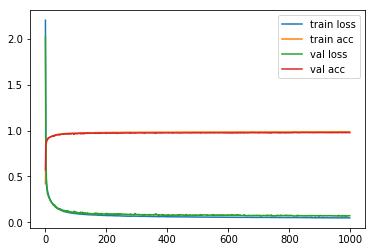

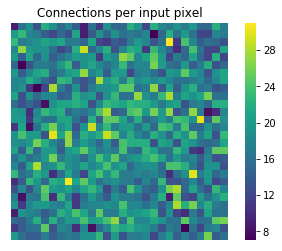

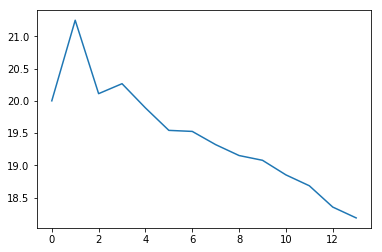

Train set: Average loss: 0.0480, Accuracy: 98.75%
Test set: Average loss: 0.0720, Accuracy: 97.77%


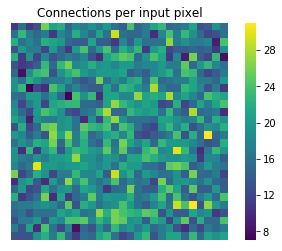

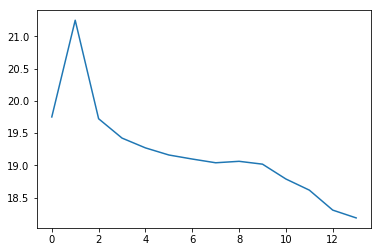

Train Epoch: 1000 [0/60000 (0%)]	Loss: 0.073855
Train Epoch: 1000 [8192/60000 (14%)]	Loss: 0.042632
Train Epoch: 1000 [16384/60000 (27%)]	Loss: 0.040565
Train Epoch: 1000 [24576/60000 (41%)]	Loss: 0.052647
Train Epoch: 1000 [32768/60000 (55%)]	Loss: 0.056356
Train Epoch: 1000 [40960/60000 (68%)]	Loss: 0.035532
Train Epoch: 1000 [49152/60000 (82%)]	Loss: 0.051455
Train Epoch: 1000 [57344/60000 (96%)]	Loss: 0.040526
Test set: Average loss: 0.0722, Accuracy: 9770/10000 (97.70%)


In [11]:
import time
epochs = 1000
for epoch in range(1, epochs + 1):
    #In the paper, evolutions occur on each epoch
    if epoch != 1:
        set_history.plot()
    show_MNIST_connections(sparse_net)
    if epoch != 1:
        print('Train set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(
            set_history.train_loss[epoch-2], 100. * set_history.train_acc[epoch-2]))
        print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(
            set_history.val_loss[epoch-2], 100. * set_history.val_acc[epoch-2]))
        sparse_net.evolve_connections()
        show_MNIST_connections(sparse_net)
    set_history = train(log_interval, sparse_net, device, train_loader, optimizer, epoch, set_history)
    #And smallest connections are removed during inference.
    sparse_net.zero_connections()
    set_history = test(sparse_net, device, test_loader, set_history)
    time.sleep(10)